In [1]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import datetime
import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
known = 'https://raw.githubusercontent.com/danyalahmed247/return-predictions/main/BADS_WS2021_known.csv'
unknown = 'https://raw.githubusercontent.com/danyalahmed247/return-predictions/main/BADS_WS2021_unknown.csv'

In [3]:
df_known = pd.read_csv(known, index_col='order_item_id')
df_known

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
order_item_id,,,,,,,,,,,,,
1,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
2,2016-06-22,NaN,337,152,grey,30,19.95,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
3,2016-06-22,2016-06-27,270,xxl,grey,49,79.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1
4,2016-06-22,2016-06-27,142,xxl,grey,49,99.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,0
5,2016-06-22,2016-06-27,561,xxl,grey,3,14.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,2016-09-11,2016-09-12,156,20,blue,34,29.90,713,Mrs,1959-03-21,Rhineland-Palatinate,2015-02-17,0
99997,2016-09-11,2016-09-12,156,20,brown,34,29.90,713,Mrs,1959-03-21,Rhineland-Palatinate,2015-02-17,0
99998,2016-09-11,1994-12-31,1832,xxl,black,37,26.90,47794,Mr,1985-03-01,Hamburg,2016-09-10,0


In [4]:
df_unknown = pd.read_csv(unknown, index_col='order_item_id')
df_unknown

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date
order_item_id,,,,,,,,,,,,
100001,2016-10-15,2017-01-10,1591,40,anthracite,9,69.9,56943,Mrs,1967-09-18,Baden-Wuerttemberg,2016-10-16
100002,2016-10-15,2017-01-10,1589,m,red,11,69.9,56943,Mrs,1967-09-18,Baden-Wuerttemberg,2016-10-16
100003,2016-10-15,2017-01-10,1589,s,red,11,69.9,56943,Mrs,1967-09-18,Baden-Wuerttemberg,2016-10-16
100004,2016-10-15,2017-01-10,1776,unsized,berry,41,49.9,56943,Mrs,1967-09-18,Baden-Wuerttemberg,2016-10-16
100005,2016-10-15,2017-01-10,2140,unsized,grey,102,59.9,56943,Mrs,1967-09-18,Baden-Wuerttemberg,2016-10-16
...,...,...,...,...,...,...,...,...,...,...,...,...
149996,2016-12-12,2016-12-13,1669,42,brown,43,89.9,48001,Mrs,NaN,Lower Saxony,2015-02-17
149997,2016-12-12,2016-12-13,1409,L,ash,3,16.9,48001,Mrs,NaN,Lower Saxony,2015-02-17
149998,2016-12-12,2016-12-13,114,42,brown,43,79.9,48001,Mrs,NaN,Lower Saxony,2015-02-17


# 2. Explanatory data analysis and Data preparation

In [5]:
def return_per_feat(x):
    feat = pd.DataFrame(df_known[x]) 
    feat_returns = pd.DataFrame(df_known.groupby([x])['return'].transform('sum'))
    feat_count = pd.DataFrame(df_known.groupby([x])[x].transform('size'))

    feat = feat.join(feat_count, on=feat.index, how='left', lsuffix='_', rsuffix='_count')
    feat = feat.join(feat_returns, on=feat.index, how='left', lsuffix='_', rsuffix='_')
    
    feat['return_per_' + x] = np.round(feat['return'] / feat[x + '_count'], 2)

    return feat


## **2.1. Dates**

array([<AxesSubplot:title={'center':'delivered'}>], dtype=object)

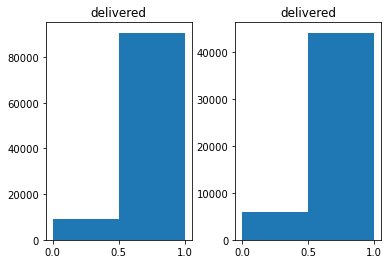

In [6]:
#Create new binary column where we set Delivered = 1 if delivery date exists, else Delivered = 0 for items without any delivery date.
check_known_delivery = df_known['delivery_date'].notnull() #returns boolean value classifying non-null values as True and null values as False
df_known['delivered'] = check_known_delivery.map({False:0, True: 1}) #map false as zero, and True as one

check_unknown_delivery = df_unknown['delivery_date'].notnull()
df_unknown['delivered'] = check_unknown_delivery.map({False:0, True: 1})

#Checking distribution of new feature
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))
df_known.hist('delivered', bins=2, ax=axes[0], grid=False)
df_unknown.hist('delivered', bins=2, ax=axes[1], grid=False)

<AxesSubplot:xlabel='delivered'>

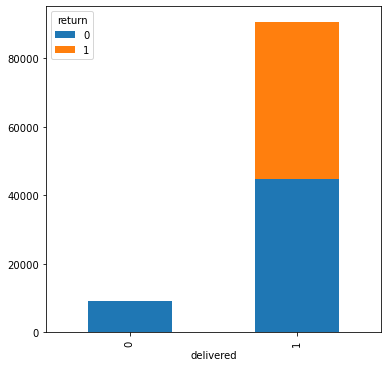

In [7]:
plt.rcParams['figure.figsize'] = (6,6)
df_known.groupby(['delivered', 'return']).size().unstack().plot(kind='bar', stacked=True)

In [8]:
# Change type of date columns to datetime features.
df_known['order_date'] = pd.to_datetime(df_known['order_date'])
df_known['delivery_date'] = pd.to_datetime(df_known['delivery_date'])
df_known['user_dob'] = pd.to_datetime(df_known['user_dob'])
df_known['user_reg_date'] = pd.to_datetime(df_known['user_reg_date'])

df_unknown['order_date'] = pd.to_datetime(df_unknown['order_date'])
df_unknown['delivery_date'] = pd.to_datetime(df_unknown['delivery_date'])
df_unknown['user_dob'] = pd.to_datetime(df_unknown['user_dob'])
df_unknown['user_reg_date'] = pd.to_datetime(df_unknown['user_reg_date'])

D:\Anaconda\Installation\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\Installation\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='delay_in_delivery', ylabel='Density'>

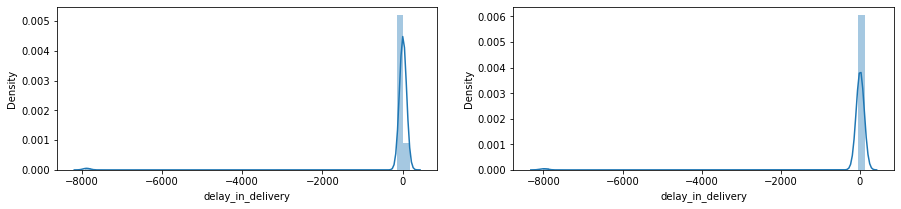

In [9]:
#Subtract Delivery date from Order Date
df_known['delay_in_delivery'] = (df_known['delivery_date'] - df_known['order_date']).dt.days #converting final value to number of days
df_unknown['delay_in_delivery'] = (df_unknown['delivery_date'] - df_unknown['order_date']).dt.days

#Checking distribution of new feature
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
sns.distplot(df_known['delay_in_delivery'], ax=axes[0])
sns.distplot(df_unknown['delay_in_delivery'], ax=axes[1])

In [10]:
#Classify all negative values
df_known.loc[df_known['delay_in_delivery'] < 0, 'delay_in_delivery'] = 0
df_unknown.loc[df_unknown['delay_in_delivery'] < 0, 'delay_in_delivery'] = 0

#Fill N/A Values - Assign a very high value to items that were not delivered
df_known['delay_in_delivery'].fillna(10000, inplace = True)
df_unknown['delay_in_delivery'].fillna(10000, inplace = True)

In [11]:
#Drop datetime columns
df_known = df_known.drop(['order_date', 'delivery_date', 'user_dob', 'user_reg_date'], axis = 1)
df_unknown = df_unknown.drop(['order_date', 'delivery_date', 'user_dob', 'user_reg_date'], axis = 1)

## 2.2. Items

In [12]:
item_ids = return_per_feat('item_id')
item_ids.head()

,item_id_,item_id_count,return,return_per_item_id
order_item_id,,,,
1,643,22,4,0.18
2,337,52,5,0.10
3,270,81,41,0.51
4,142,228,122,0.54
5,561,137,53,0.39


D:\Anaconda\Installation\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x432 with 0 Axes>

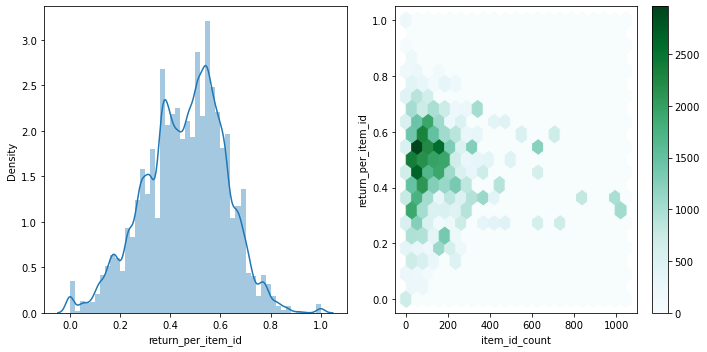

In [13]:
plt.figure(1)
fig = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax1 = plt.subplot(121)
sns.distplot(item_ids['return_per_item_id'], ax=ax1)

ax2 = plt.subplot(122)
item_ids.plot.hexbin(x='item_id_count', y='return_per_item_id', gridsize=20, ax=ax2) 

plt.tight_layout()

In [14]:
#Create a mapping dictionary consisting of item_id and return per item
map_known_items = dict(item_ids[['item_id_', 'return_per_item_id']].values)

#Map the values of return per item from the table above back to original dataset. Item Id is being used as key.
df_known['return_per_item_id'] = df_known.item_id.map(map_known_items)

In [15]:
#Create a table with item IDs from unknown data and map same values of return per item against each item ID
unknown_items = pd.DataFrame(df_unknown['item_id'])
unknown_items['return_per_item_id'] = unknown_items.item_id.map(map_known_items)

#Since Unknown data has new items, our dict is not able to assign any value of return per item to those items and they are left Null.
unknown_items['return_per_item_id'].fillna(0.5, inplace = True) #Assign a value of 0.5 Null values since we dont have data about them.

#Map final values of unknown returns per item back to df-unknown
map_unknown_items = dict(unknown_items[['item_id', 'return_per_item_id']].values)

df_unknown['return_per_item_id'] = df_unknown.item_id.map(map_unknown_items)

## 2.3 Sizes

In [16]:
#Classify all sizes that makeup less than 1% of the sizes distribution as 'Other'
known_size_check = pd.DataFrame(df_known['item_size']) #Create a seperate Dataframe for sizes only
known_series_sizes = pd.value_counts(known_size_check.item_size) #Assigning value counts of all sizes to a variable called series

#Assign boolean values to the series above. All sizes which have a count less than 1% of the distribution are classified as TRUE. Rest are FALSE.
known_mask_size = (known_series_sizes/known_series_sizes.sum() * 100).lt(1) #lt(1) means less than 1%

#Replace sizes in known dataset with masked series
df_known['item_size'] = np.where(df_known['item_size'].isin(known_series_sizes[known_mask_size].index),'Other',df_known['item_size'])

#Same masking done for unknown dataset
unknown_size_check = pd.DataFrame(df_unknown['item_size']) 
unknown_series_sizes = pd.value_counts(unknown_size_check.item_size)
unknown_mask_size = (unknown_series_sizes/unknown_series_sizes.sum() * 100).lt(1)

df_unknown['item_size'] = np.where(df_unknown['item_size'].isin(unknown_series_sizes[unknown_mask_size].index),'Other',df_unknown['item_size'])

In [17]:
#Combining multiple similar categories into one for unknown dataset
df_unknown['item_size'] = df_unknown['item_size'].str.replace('L', 'l')
df_unknown['item_size'] = df_unknown['item_size'].str.replace('M', 'm')
df_unknown['item_size'] = df_unknown['item_size'].str.replace('XXl', 'xxl')
df_unknown['item_size'] = df_unknown['item_size'].str.replace('S', 's')
df_unknown['item_size'] = df_unknown['item_size'].str.replace('Xl', 'xl')

<AxesSubplot:xlabel='item_size_', ylabel='return_per_item_size'>

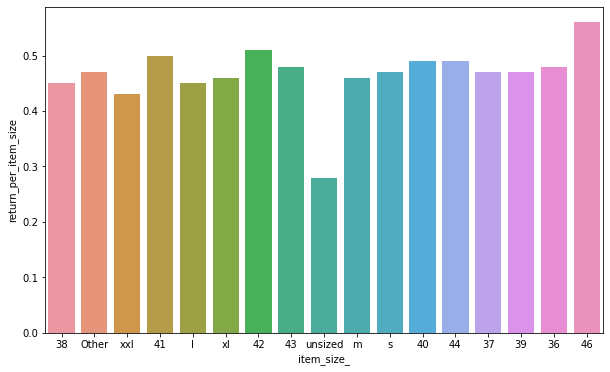

In [18]:
sizes = return_per_feat('item_size')
plt.rcParams['figure.figsize'] = (10,6)
sns.barplot(x="item_size_", y="return_per_item_size", data=sizes)

In [19]:
map_known_sizes = dict(sizes[['item_size_', 'return_per_item_size']].values)
df_known['return_per_size'] = df_known.item_size.map(map_known_sizes)

#Create a table for unknown sizes with return rates mapped from known data.
unknown_sizes = pd.DataFrame(df_unknown['item_size'])
unknown_sizes['return_per_size'] = unknown_sizes.item_size.map(map_known_sizes)

#Assign a probability of 0.5 for sizes in unknown data that are not found in known data
unknown_sizes['return_per_size'].fillna(0.5, inplace = True)

#Map final values of unknown returns per size back to df_unknown
map_unknown_sizes = dict(unknown_sizes[['item_size', 'return_per_size']].values)

df_unknown['return_per_size'] = df_unknown.item_size.map(map_unknown_sizes)

## 2.4 Color

D:\Anaconda\Installation\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='return_per_item_color', ylabel='Density'>

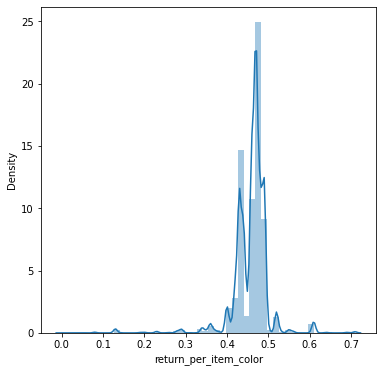

In [20]:
colors = return_per_feat('item_color')
plt.rcParams['figure.figsize'] = (6,6)
sns.distplot(colors['return_per_item_color'])

In [21]:
#Map return per color back to original dataset
map_known_colors = dict(colors[['item_color_', 'return_per_item_color']].values)
df_known['return_per_color'] = df_known.item_color.map(map_known_colors)

#Map return per color to unknown dataset
unknown_colors = pd.DataFrame(df_unknown['item_color'])
unknown_colors['return_per_color'] = unknown_colors.item_color.map(map_known_colors)

map_unknown_color = dict(unknown_colors[['item_color', 'return_per_color']].values)

df_unknown['return_per_color'] = df_unknown.item_color.map(map_unknown_color)

## 2.5 Brands

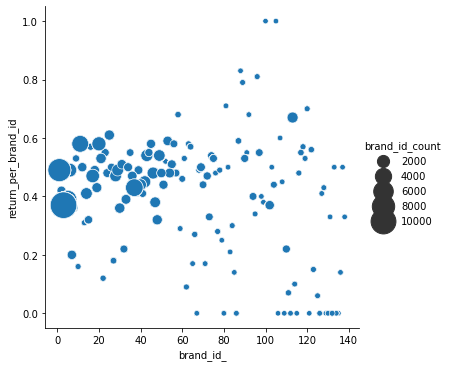

In [22]:
brands = return_per_feat('brand_id')
plt.rcParams['figure.figsize'] = (10,6)
sns.relplot(x="brand_id_", y="return_per_brand_id", size="brand_id_count",  sizes=(30, 700), data=brands)

In [23]:
#Map return per brand back to original dataset
map_known_brands = dict(brands[['brand_id_', 'return_per_brand_id']].values)
df_known['return_per_brand'] = df_known.brand_id.map(map_known_brands)

#Map back to unknown data
unknown_brands = pd.DataFrame(df_unknown['brand_id'])
unknown_brands['return_per_brand'] = unknown_brands.brand_id.map(map_known_brands)

map_unknown_brands = dict(unknown_brands[['brand_id', 'return_per_brand']].values)

df_unknown['return_per_brand'] = df_unknown.brand_id.map(map_unknown_brands)

## 2.6 Prices

(0.0, 500.0)

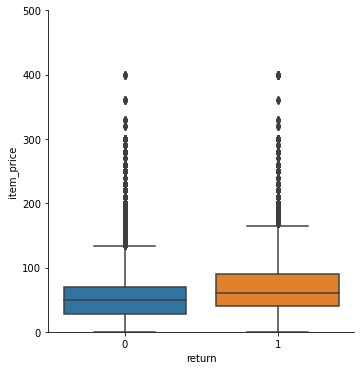

In [24]:
df_known.item_price = df_known.item_price.round()
df_unknown.item_price = df_unknown.item_price.round()

plt.rcParams['figure.figsize'] = (10,6)
sns.catplot(x="return", y="item_price", hue="return",
            kind="box", dodge=False, data=df_known)
plt.ylim(0, 500) #setting a limit to y-axis so we can visualize the distribution properly

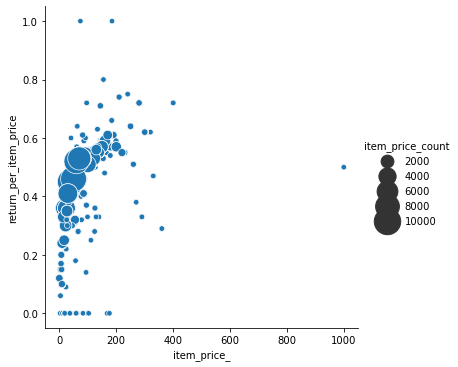

In [25]:
prices = return_per_feat('item_price')
plt.rcParams['figure.figsize'] = (10,6)
sns.relplot(x="item_price_", y="return_per_item_price", size="item_price_count",  sizes=(30, 700), data=prices)

In [26]:
#Map return per price back to original dataset
map_known_prices = dict(prices[['item_price_', 'return_per_item_price']].values)
df_known['return_per_price'] = df_known.item_price.map(map_known_prices)

unknown_prices = pd.DataFrame(df_unknown['item_price'])
unknown_prices['return_per_price'] = unknown_prices.item_price.map(map_known_prices)

#Replace null values with 0.5
unknown_prices['return_per_price'].fillna(0.5, inplace = True)

#Map final values of unknown returns per size back to df-unknown
map_unknown_prices = dict(unknown_prices[['item_price', 'return_per_price']].values)
df_unknown['return_per_price'] = df_unknown.item_price.map(map_unknown_prices)

## 2.7 Users

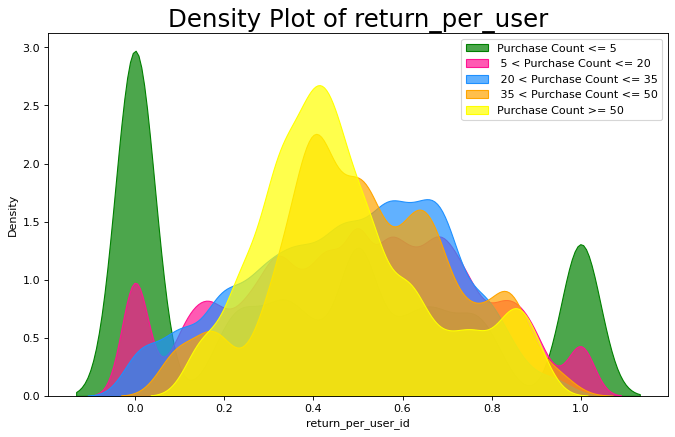

In [27]:
users = return_per_feat('user_id')

plt.figure(figsize=(10,6), dpi= 80)
sns.kdeplot(users.loc[users['user_id_count'] <= 5, 'return_per_user_id'], shade=True, color="g", label="Purchase Count <= 5", alpha=.7)
sns.kdeplot(users.loc[(users['user_id_count'] > 5) & (users['user_id_count'] <= 20), 'return_per_user_id'] , shade=True, color="deeppink", label=" 5 < Purchase Count <= 20", alpha=.7)
sns.kdeplot(users.loc[(users['user_id_count'] > 20) & (users['user_id_count'] <= 35), 'return_per_user_id'] , shade=True, color="dodgerblue", label=" 20 < Purchase Count <= 35", alpha=.7)
sns.kdeplot(users.loc[(users['user_id_count'] > 35) & (users['user_id_count'] <= 50), 'return_per_user_id'] , shade=True, color="orange", label=" 35 < Purchase Count <= 50", alpha=.7)
sns.kdeplot(users.loc[users['user_id_count'] >= 50, 'return_per_user_id'], shade=True, color="yellow", label="Purchase Count >= 50", alpha=.7)

plt.title('Density Plot of return_per_user', fontsize=22)
plt.legend()
plt.show()

In [28]:
users.loc[users['user_id_count'] < 5, 'return_per_user_id'] = .50

#Map return per user values back to original dataframe
map_known_users = dict(users[['user_id_', 'return_per_user_id']].values)
df_known['return_per_user'] = df_known.user_id.map(map_known_users)

#Map final values of unknown returns per size back to df-unknown
unknown_users = pd.DataFrame(df_unknown['user_id'])
unknown_users['return_per_user'] = unknown_users.user_id.map(map_known_users)

unknown_users['return_per_user'].fillna(0.5, inplace = True)

map_unknown_users = dict(unknown_users[['user_id', 'return_per_user']].values)
df_unknown['return_per_user'] = df_unknown.user_id.map(map_unknown_users)

<AxesSubplot:xlabel='new_user'>

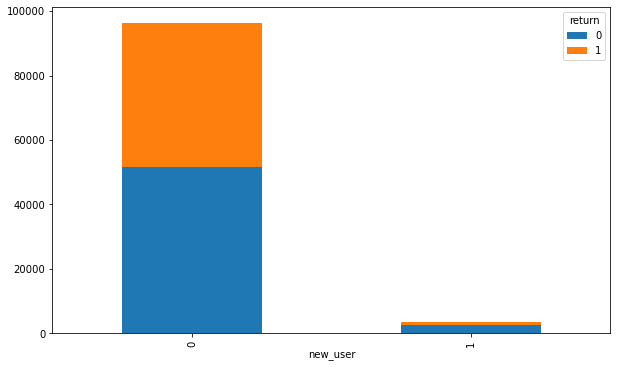

In [29]:
#Create a feature in the known and unknown dataframes which records the frequency of all user ids.
known_user_count = pd.DataFrame(df_known.groupby(['user_id'])['user_id'].transform('size'))
df_known = df_known.join(known_user_count, on=df_known.index, how='left', lsuffix='_', rsuffix='_count')

unknown_user_count = pd.DataFrame(df_unknown.groupby(['user_id'])['user_id'].transform('size'))
df_unknown = df_unknown.join(unknown_user_count, on=df_unknown.index, how='left', lsuffix='_', rsuffix='_count')

#Create a new_user feature in both datasets where new_user = 1 if user_id_count is less than or equal to 1. Otherwise set it to 0.
df_known['new_user'] = np.where(df_known['user_id_count'] <= 1, 1, 0)
df_unknown['new_user'] = np.where(df_unknown['user_id_count'] <= 1, 1, 0)

plt.rcParams['figure.figsize'] = (10,6)
df_known.groupby(['new_user', 'return']).size().unstack().plot(kind='bar', stacked=True)

In [30]:
#Drop unecassary count features
df_known = df_known.drop(['user_id_count'], axis=1)
df_known.rename(columns={'user_id_': 'user_id'}, inplace=True)

df_unknown = df_unknown.drop(['user_id_count'], axis=1)
df_unknown.rename(columns={'user_id_': 'user_id'}, inplace=True)

## 2.8 Modified DataFrame

<AxesSubplot:>

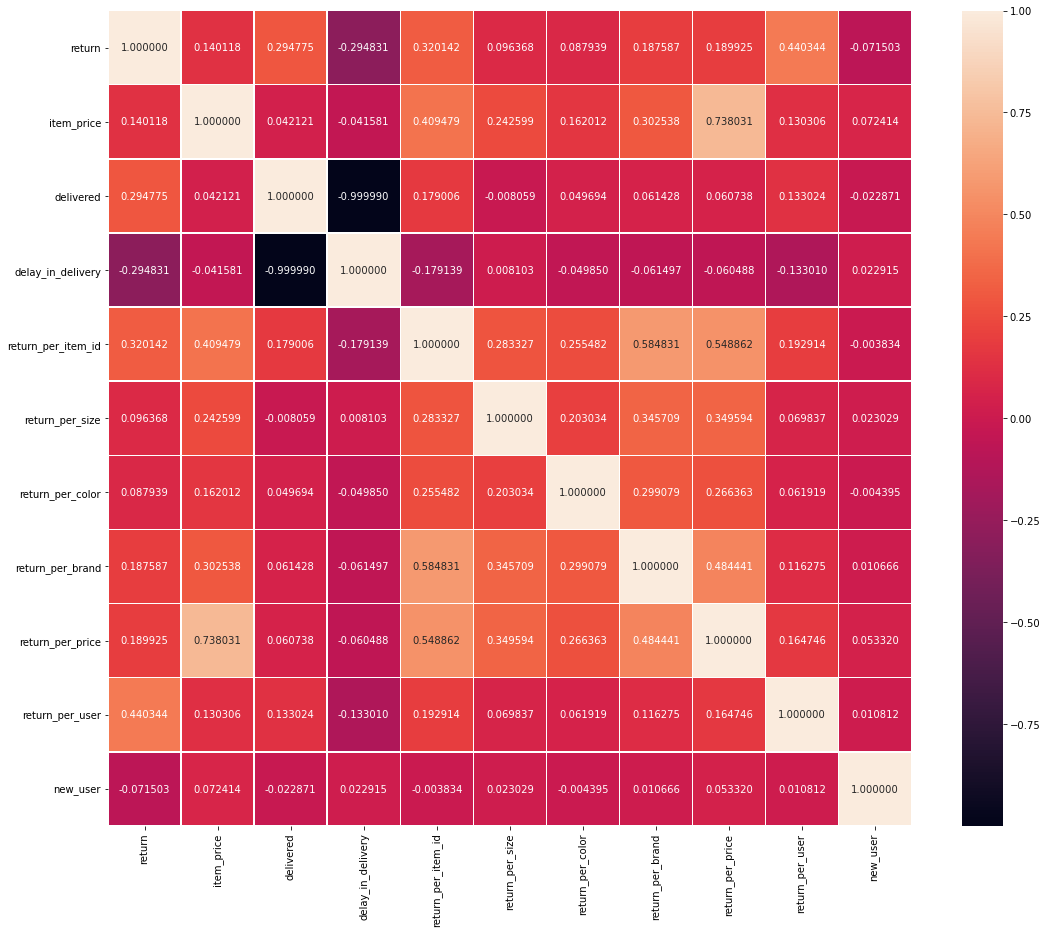

In [31]:
X = df_known.drop(['item_id', 'item_size', 'item_color', 'brand_id', 'user_id', 'user_title', 'user_state'], axis=1)
X = X[['return'] + [ col for col in X.columns if col != 'return' ]] #Rearrange df such that the return column is at the begining

#Plot correlation heatmap
corr = X.corr()
f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr ,annot=True,linewidth=.5,fmt='1f')

In [32]:
#Prepare seperate dataframes to pass into model
X = X.drop(['return'], axis=1)
y = df_known['return']

X.head()

,item_price,delivered,delay_in_delivery,return_per_item_id,return_per_size,return_per_color,return_per_brand,return_per_price,return_per_user,new_user
order_item_id,,,,,,,,,,
1,50.0,1,5.0,0.18,0.45,0.29,0.36,0.46,0.50,0
2,20.0,0,10000.0,0.10,0.47,0.48,0.36,0.36,0.50,0
3,80.0,1,5.0,0.51,0.43,0.48,0.54,0.53,0.59,0
4,100.0,1,5.0,0.54,0.43,0.48,0.54,0.51,0.59,0
5,15.0,1,5.0,0.39,0.43,0.48,0.37,0.33,0.59,0


# 3. Model Comparison, Selection and Tuning

In [33]:
# Initialize Models
models = []

#Pass the following models into the list
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))


results = []
names = []

#Set evaluation metric as AUC Score
scoring = 'roc_auc' 

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=888, shuffle=True) #split folds into random train and test subsets
    cv_models = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring) 
 
    results.append(cv_models) #pass the results of the loop into the results list and move on to next loop
    names.append(name)
 
 #Print Name of model along with best evaluation metrics
    out = "%s: %f" % (name, np.round(cv_models.mean(), 3))
    print(out)

D:\Anaconda\Installation\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Anaconda\Installation\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LR: 0.824000
DT: 0.673000
RF: 0.795000
[00:43:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\Installation\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\Installation\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:43:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\Installation\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:43:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\Installation\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:43:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\Installation\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:43:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\Installation\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:43:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\Installation\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:43:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\Installation\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:43:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\Installation\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:43:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\Installation\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:44:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB: 0.828000


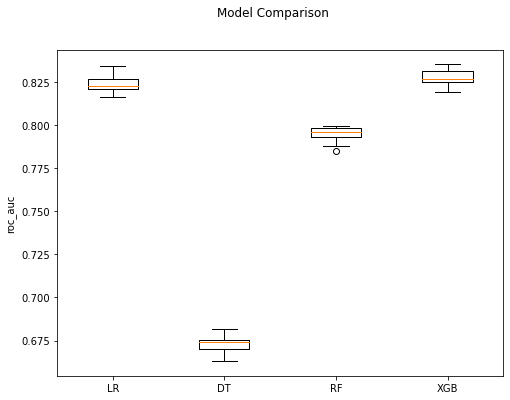

In [34]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel(scoring)
plt.show()

# 4. Model Evaluation

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=888)

D:\Anaconda\Installation\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:44:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:44:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


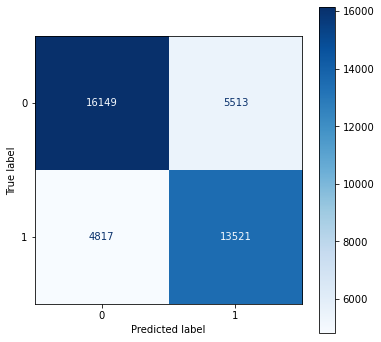

In [36]:
#Final Model
xgb_model = xgb.XGBClassifier(
    learning_rate = 0.1,
    colsample_bytree = 0.5,
    n_estimators = 300,
    max_depth = 3,
    min_child_weight=1,
    gamma= 0.4,
    subsample=0.8,
    objective = 'binary:logistic',
    early_stopping_rounds = 100,
    reg_alpha = 0.01,
    seed = 888
    )

#Fit the model on training data
xgb_model.fit(X_train, y_train)

#Plot confusion matrix after applying model on test data
plt.rcParams['figure.figsize'] = (6,6)
metrics.plot_confusion_matrix(xgb_model, X_test, y_test,  cmap=plt.cm.Blues, values_format='d')

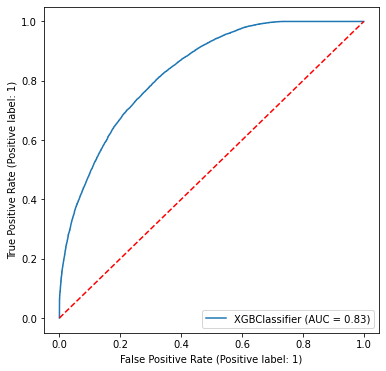

In [37]:
plt.rcParams['figure.figsize'] = (6,6)
predict_xgb = xgb_model.predict_proba(X_test)[:, 1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predict_xgb)
auc_score = auc(false_positive_rate, true_positive_rate)

metrics.plot_roc_curve(xgb_model, X_test, y_test)
plt.plot([0, 1], [0, 1], "r--");

Text(0.5, 1.0, 'Feature Importance')

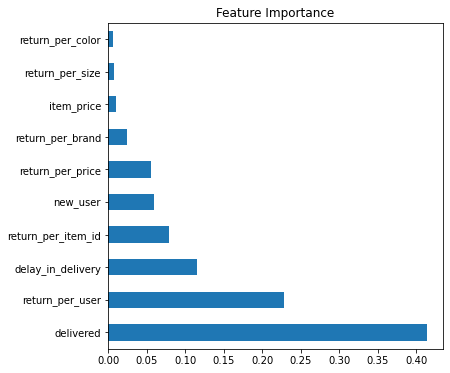

In [38]:
#Plot feature importance in our final model
plt.rcParams['figure.figsize'] = (6,6)
X_labels = X.columns[0:10]
feat_importance = pd.Series(xgb_model.feature_importances_, index= X_labels)
feat_importance.nlargest(20).plot(kind='barh')
plt.title("Feature Importance")

# 5. Cost Evaluation

In [40]:
#Apply predictions on entire X dataframe
cost_table = pd.DataFrame(X['item_price'])
cost_table['pred_return'] = xgb_model.predict_proba(X)[:, 1]

#Define bayes threshold
fp_cost = 0.5 * cost_table['item_price'] #false postive costs
fn_cost = 0.5 * 5 * (3 + 0.1 * cost_table['item_price']) #false negative costs
bayes_threshold = fp_cost/(fp_cost + fn_cost)
cost_table['bayes_threshold'] = bayes_threshold

cost_table['default_return'] = np.where(cost_table.pred_return >= 0.50, 1, 0) #Create column where return = 1 if predicted probability > 0.5, else 0
cost_table['bayes_return'] = np.where(cost_table.pred_return >= cost_table.bayes_threshold, 1, 0) #Create column where return = 1 if predicted probability > bayes threshold, else 0
cost_table['actual_return'] = y #Column with actual return values

print("The accuracy of the model using the default cutoff is: {}".format(accuracy_score(y, cost_table.default_return)))
print("The accuracy of the model using the cost-minimal cutoff is: {}".format(accuracy_score(y, cost_table.bayes_return)))

The accuracy of the model using the default cutoff is: 0.74174
The accuracy of the model using the cost-minimal cutoff is: 0.72684


In [41]:
def default_cost_func(row): #cost of default threshold
    if row['actual_return'] == row['default_return']: #no cost for correct predictions
        val = 0
    elif row['actual_return'] > row['default_return']: #if actual_return = 1 and predicted default_return = 0, then apply false negative formula
        val = 0.5 * 5 * (3 + 0.1 * row['item_price'])
    else:
        val = 0.5 * row['item_price'] #if actual_return = 0 and predicted default_return = 1, then apply false positive formula
    return val

def bayes_cost_func(row): #cost of bayes threshold
    if row['actual_return'] == row['bayes_return']:  #no cost for correct predictions
        val = 0
    elif row['actual_return'] > row['bayes_return']: #if actual_return = 1 and predicted bayes_return = 0, then apply false negative formula
        val = 0.5 * 5 * (3 + 0.1 * row['item_price'])
    else:
        val = 0.5 * row['item_price'] #if actual_return = 0 and predicted bayes_return = 1, then apply false positive formula
    return val

In [42]:
#Apply functions to create new columns
cost_table['default_cost'] = cost_table.apply(default_cost_func, axis=1)
cost_table['bayes_cost'] = cost_table.apply(bayes_cost_func, axis=1)
cost_table

,item_price,pred_return,bayes_threshold,default_return,bayes_return,actual_return,default_cost,bayes_cost
order_item_id,,,,,,,,
1,50.0,0.216213,0.555556,0,0,0,0.0,0.0
2,20.0,0.000153,0.444444,0,0,0,0.0,0.0
3,80.0,0.671466,0.592593,1,1,1,0.0,0.0
4,100.0,0.696809,0.606061,1,1,0,50.0,50.0
5,15.0,0.646347,0.400000,1,1,1,0.0,0.0
...,...,...,...,...,...,...,...,...
99996,30.0,0.480506,0.500000,0,0,0,0.0,0.0
99997,30.0,0.488737,0.500000,0,0,0,0.0,0.0
99998,27.0,0.361909,0.486486,0,0,0,0.0,0.0


In [43]:
print("The total error cost based on default cutoff is: {}".format(np.sum(cost_table.default_cost)))
print("The total error cost based on bayes cutoff is: {}".format(np.sum(cost_table.bayes_cost)))

The total error cost based on default cutoff is: 783620.0
The total error cost based on bayes cutoff is: 746414.25


# 6. Predictions

In [45]:
#Drop unnecessary columns from the unknown dataset
X_unknown = df_unknown.drop(['item_id', 'item_size', 'item_color', 'brand_id', 'user_id', 'user_title', 
                             'user_state'], axis=1)

#Apply model on unknown dataset for return probabilities 
return_probabilities = xgb_model.predict_proba(X_unknown)[:, 1]

#Create kaggle validation table with return probabilities against each order id
order_id = df_unknown.index
kaggle_table = pd.DataFrame(order_id, columns = ['order_item_id'])
kaggle_table['return_prob'] =  return_probabilities
kaggle_table = kaggle_table.set_index('order_item_id')

#create new table for unknown predictions based on bayes threshold
unknown_price = pd.DataFrame(df_unknown['item_price'])
unknown_cost_table = kaggle_table.join(unknown_price, on=kaggle_table.index, how='left', lsuffix='_', rsuffix='_') #join unknown item price with kaggle table

#define bayes threshold for each order
unknown_fp_cost = 0.5 * unknown_cost_table['item_price']
unknown_fn_cost = 0.5 * 5 * (3 + 0.1 * unknown_cost_table['item_price'])
unknown_bayes_ratio = unknown_fp_cost/(unknown_fp_cost + unknown_fn_cost)
unknown_cost_table['unknown_bayes_ratio'] = unknown_bayes_ratio

#create default return predictions and optimal return predictions based on Bayes Threshold
unknown_cost_table['default_return'] = np.where(unknown_cost_table.return_prob >= 0.5, 1,0) #for default cutoff
unknown_cost_table['optimal_return'] = np.where(unknown_cost_table.return_prob >= unknown_cost_table.unknown_bayes_ratio, 1,0) #for bayes threshold

unknown_cost_table

,return_prob,item_price,unknown_bayes_ratio,default_return,optimal_return
order_item_id,,,,,
100001,0.424009,70.0,0.583333,0,0
100002,0.490269,70.0,0.583333,0,0
100003,0.502893,70.0,0.583333,1,0
100004,0.513345,50.0,0.555556,1,0
100005,0.402915,60.0,0.571429,0,0
...,...,...,...,...,...
149996,0.722022,90.0,0.600000,1,1
149997,0.338006,17.0,0.419753,0,0
149998,0.631874,80.0,0.592593,1,1


In [46]:
#Create final returns table based on Bayes Threshold
final_predictions_table = unknown_cost_table.copy()
final_predictions_table = final_predictions_table.drop(['default_return', 'unknown_bayes_ratio', 'item_price', 'return_prob'], axis = 1)
final_predictions_table.rename(columns={'optimal_return':'return'}, inplace=True)
final_predictions_table

,return
order_item_id,
100001,0
100002,0
100003,0
100004,0
100005,0
...,...
149996,1
149997,0
149998,1


In [ ]:
#Export as CSV file
final_predictions_table.to_csv('Final Predictions.csv') 
files.download("Final Predictions.csv")